## **Unet architect**

- https://www.mdpi.com/2079-9292/12/18/3808

In [2]:
import torch
import torch.nn as nn

torch.manual_seed(0)

In [3]:
class Conv(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, **kwargs):
        super().__init__()

        self.layer = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, **kwargs),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU()
        )

    def forward(self, x):
        return self.layer(x)

In [4]:
class ExtractionBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()

        self.conv1 = Conv(in_channels, out_channels, kernel_size=1)
        self.conv3 = nn.Sequential(
            Conv(in_channels, out_channels, kernel_size=3, padding=1),
            Conv(out_channels, out_channels, kernel_size=3, padding=1)
        )

    def forward(self, x):
        return self.conv1(x) + self.conv3(x)

class UpExtractionBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()

        self.transpose = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)
        self.extract = ExtractionBlock(out_channels*2, out_channels)

    def forward(self, x, concat):
        x = torch.concat([self.transpose(x), concat], dim=1)
        x = self.extract(x)
        return x



In [5]:
class Unet(nn.Module):
    def __init__(self, in_channels):
        super().__init__()

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.extract1 = ExtractionBlock(in_channels, 64)
        self.extract2 = ExtractionBlock(64, 128)
        self.extract3 = ExtractionBlock(128, 256)
        self.extract4 = ExtractionBlock(256, 512)

        self.extract4_1 = ExtractionBlock(512, 512)
        self.extract4_2 = ExtractionBlock(1024,512)

        self.extract5 = UpExtractionBlock(512, 256)
        self.extract6 = UpExtractionBlock(256, 128)
        self.extract7 = UpExtractionBlock(128, 64)

        self.layer = nn.Sequential(
            nn.Conv2d(64, 1, kernel_size=1),
            nn.Tanh()
        )

    def forward(self, x):
        x1 = self.extract1(x)
        x2 = self.extract2(self.pool(x1))
        x3 = self.extract3(self.pool(x2))
        x4 = self.extract4(self.pool(x3))

        x5 = self.extract4_1(x4)
        x  = torch.concat([x5, x4], dim=1)
        x  = self.extract4_2(x)
        
        x  = self.extract5(x, x3)
        x  = self.extract6(x, x2)
        x  = self.extract7(x, x1)

        return (self.layer(x) + 1) / 2


In [6]:
import kornia
import qrcode
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

In [7]:
def rgb_to_yuv(tensor):

    yuv = kornia.color.rgb_to_yuv(tensor)
    Y = yuv[:, 0:1, :, :]
    U = yuv[:, 1:2, :, :]
    V = yuv[:, 2:3, :, :]

    return Y, U, V

def yuv_to_rgb(Y, U, V):

    yuv_merged = torch.cat([Y, U, V], dim=1)
    rgb = kornia.color.yuv_to_rgb(yuv_merged)

    return rgb


In [75]:
def generate_qr(data, size=200):

    qr = qrcode.QRCode(
        version=10,
        error_correction=qrcode.constants.ERROR_CORRECT_H,
        box_size=5,
        border=0
    )
    qr.add_data(data)
    qr.make(fit=True)

    img = qr.make_image(fill_color="white", back_color="black").convert("RGB")
    img = img.resize((size, size), Image.NEAREST)

    img_np = np.array(img)
    img_tensor = torch.from_numpy(img_np).float()
    return img_tensor.permute(2,0,1)


## **Load Models**

In [76]:
ExtractNetwork = Unet(3)
ExtractNetwork.load_state_dict(torch.load('E_epoch30.pth', map_location='cpu'))
HiddenNetwork = Unet(2)
HiddenNetwork.load_state_dict(torch.load('H_epoch30.pth', map_location='cpu'))

<All keys matched successfully>

In [13]:
from torchvision import transforms

In [91]:
def create_stego(cover_path, secret_path, image_size):
    transform = transforms.Compose([
            transforms.Resize((image_size, image_size)),
            transforms.PILToTensor()
    ]) 

    cover = transform(Image.open(cover_path)) if isinstance(cover_path, str) else cover_path
    secret= transform(Image.open(secret_path))if isinstance(secret_path, str) else secret_path

    cover = (cover / 255).unsqueeze(0)
    secret= (secret / 255).unsqueeze(0)

    Y, U, V = rgb_to_yuv(cover)
    secret_Y, _, _ = rgb_to_yuv(secret)
    X = torch.concat([Y, secret_Y], dim=1)

    stego = HiddenNetwork(X)
    stego_rgb = yuv_to_rgb(stego, U, V)

    return cover, secret, stego_rgb


def extract_secret(stego):
    return ExtractNetwork(stego)


def show(*img, labels):

    plt.figure(figsize=(10, 5))

    for idx, i in enumerate(img):
        x = i.squeeze(0)
        x = x.permute(1,2,0)
        x = x.clamp(0, 255)
        plt.subplot(1, len(img), idx+1)
        plt.title(labels[idx], fontsize=14)
        plt.imshow(x.detach(), cmap='gray')


In [99]:
import glob
from random import choice

sample = glob.glob('pepe_dataset/*.jpg')


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0439692].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.65396].


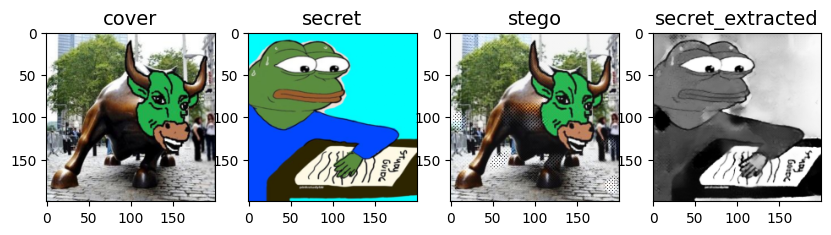

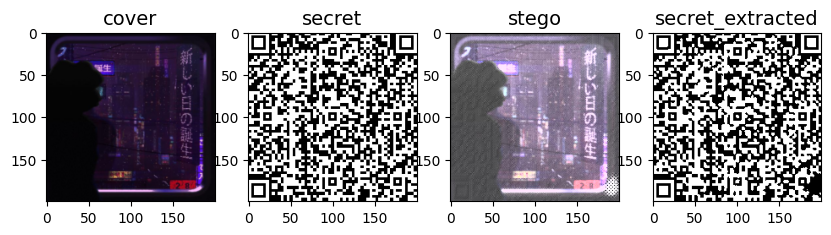

In [120]:
cover, secret, stego = create_stego(choice(sample), choice(sample), 200)
secret_extracted = extract_secret(stego)


show(cover, secret, stego, secret_extracted, labels=['cover', 'secret', 'stego', 'secret_extracted'])


cover, secret, stego = create_stego(choice(sample), generate_qr('https://github.com/naturesh'), 200)
secret_extracted = extract_secret(stego)


show(cover, secret, stego, (secret_extracted > secret_extracted.mean())*255, labels=['cover', 'secret', 'stego', 'secret_extracted'])